### Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import util

pd.options.display.max_columns=25
sns.set_style('white')

/Users/scott/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load data

In [2]:
df, df_shops, df_ingredients = util.load_burritos()
df.tail(20)

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes
339,el rey moro,hashbrown,8/20/2017,6.47,4.0,450.0,0.625000,22.5,20.0,0.72,3.0,3.0,2.0,2.5,1.5,2.5,2.5,3.0,5.0,3.20,NaN,scott,NaN
340,el rey moro,hashbrown,8/20/2017,8.94,3.5,NaN,NaN,21.5,22.0,0.83,2.5,3.5,3.5,3.5,3.5,4.0,3.0,3.5,4.5,3.80,NaN,emily,NaN
341,taco villa,carnitas,8/25/2017,5.99,2.0,NaN,NaN,20.0,21.5,0.74,2.0,2.5,4.0,3.0,4.0,3.5,3.0,3.0,5.0,3.80,NaN,scott,NaN
342,taco villa,carne asada,8/25/2017,6.99,3.5,NaN,NaN,NaN,NaN,NaN,4.0,4.0,4.0,4.5,4.0,3.5,4.0,4.0,4.0,4.30,NaN,nuttida,NaN
343,los tacos,local,9/4/2017,8.50,3.5,540.0,0.683544,21.5,21.5,0.79,3.5,4.0,4.5,4.0,3.0,4.0,3.5,4.5,5.0,4.30,NaN,scott,NaN
344,los tacos,local,9/4/2017,8.50,3.5,540.0,0.613636,21.0,23.0,0.88,4.0,4.0,4.0,4.5,4.2,4.5,4.0,4.5,4.8,4.50,NaN,emily,NaN
345,rigoberto's taco shop,california,9/5/2017,6.85,3.5,NaN,NaN,22.5,22.5,0.91,3.0,4.5,3.8,3.8,4.0,3.5,3.5,4.0,3.0,4.10,NaN,scott,NaN
346,rigoberto's taco shop,california,9/5/2017,6.85,3.5,NaN,NaN,22.2,22.5,0.89,3.0,4.5,4.0,4.0,4.5,3.0,4.0,4.0,3.5,4.25,NaN,sage,NaN
347,taco stand,california,12/29/2017,7.89,4.0,NaN,NaN,19.0,23.0,0.80,4.0,3.0,4.0,4.0,3.0,4.0,3.5,4.3,4.5,4.20,NaN,scott,NaN
348,taco stand,california,12/29/2017,7.89,5.0,NaN,NaN,20.0,21.5,0.74,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.50,NaN,ben s,NaN


### Analyze correlations between features

In [3]:
# Throw out outlier data
df_use = df.copy()
df_use = df_use[df_use['Cost'] < 9]
df_use = df_use[df_use['Cost'] > 5]
df_use = df_use[np.logical_or(df_use['Volume'] < 1.5, df_use['Volume'].isnull())]
df_use = df_use[np.logical_or(df_use['Volume'] > 0.5, df_use['Volume'].isnull())]

# Compute correlation matrix
m_corr = ['Hunger','Cost','Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
               'Uniformity','Salsa','Wrap','overall']
dfcorr = df_use[m_corr].corr(method='spearman')
for feat in m_corr:
    dfcorr.loc[feat, feat] = np.nan

# Determine the most highly correlated feature for each other feature
for feat in m_corr:
    feat2 = dfcorr[feat].argmax()
    print(feat, feat2,
          stats.spearmanr(df_use[feat], df_use[feat2], nan_policy='omit')[0],
          stats.spearmanr(df_use[feat], df_use[feat2], nan_policy='omit')[1])

Hunger Tortilla 0.16210460792504133 0.0034843054965283957
Cost Volume 0.29343406064587807 8.762985204375658e-06
Volume Cost 0.29343406064587807 8.762985204375658e-06
Tortilla overall 0.37109157164009765 5.536908530915314e-12
Temp overall 0.27270908437729424 9.65351976119145e-07
Meat overall 0.6826934469305921 5.733970606690913e-45
Fillings overall 0.667096617954374 1.0872797135089455e-42
Meat:filling Uniformity 0.4539582295725544 1.1296865519642829e-17
Uniformity Meat:filling 0.4539582295725544 1.1296865519642829e-17
Salsa overall 0.43919714798198983 5.290476487395816e-16
Wrap Uniformity 0.24395645621584505 9.223545606661328e-06
overall Meat 0.6826934469305921 5.733970606690913e-45


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


In [4]:
# Compute correlation matrix for restaurants
df_rest = df_use.groupby('Location')[m_corr].mean()
df_rest_corr = df_rest.corr(method='spearman')
for feat in m_corr:
    df_rest_corr.loc[feat, feat] = np.nan

# Determine the most highly correlated feature for each other feature
for feat in m_corr:
    feat2 = df_rest_corr[feat].argmax()
    print(feat, feat2,
          stats.spearmanr(df_rest[feat], df_rest[feat2], nan_policy='omit')[0],
          stats.spearmanr(df_rest[feat], df_rest[feat2], nan_policy='omit')[1])

Hunger overall 0.1906135094874499 0.10623675128266782
Cost Volume 0.34080656185919345 0.010161270954420399
Volume Fillings 0.3938653451811347 0.0026701207235313084
Tortilla overall 0.4127566947906524 0.00028457431947815753
Temp overall 0.3583067369368642 0.0018545990253249693
Meat overall 0.7624672910746544 4.611620317174234e-15
Fillings overall 0.7110817649106437 1.8023795307310645e-12
Meat:filling overall 0.39708846399657693 0.000504506179823083
Uniformity Meat:filling 0.38086284025525136 0.0008868463561284776
Salsa overall 0.6152414486921529 1.1364496418831473e-08
Wrap Meat:filling 0.19620579816653339 0.09617987176850994
overall Meat 0.7624672910746545 4.611620317174183e-15


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  if __name__ == '__main__':


In [5]:
print(stats.spearmanr(df_rest['Meat'], df_rest['Meat:filling'], nan_policy='omit'))
print(stats.spearmanr(df_use['Meat'], df_use['Meat:filling'], nan_policy='omit'))

print(stats.spearmanr(df_rest['Fillings'], df_rest['Meat:filling'], nan_policy='omit'))
print(stats.spearmanr(df_use['Fillings'], df_use['Meat:filling'], nan_policy='omit'))

print(stats.spearmanr(df_rest['Fillings'], df_rest['Meat'], nan_policy='omit'))
print(stats.spearmanr(df_use['Fillings'], df_use['Meat'], nan_policy='omit'))

SpearmanrResult(correlation=0.38306617119655706, pvalue=0.0008228287383089586)
SpearmanrResult(correlation=0.32647941680960546, pvalue=masked_array(data=2.33404376e-09,
             mask=False,
       fill_value=1e+20))
SpearmanrResult(correlation=0.3142069793566162, pvalue=0.006785733773543565)
SpearmanrResult(correlation=0.23210877303489297, pvalue=masked_array(data=2.74991078e-05,
             mask=False,
       fill_value=1e+20))
SpearmanrResult(correlation=0.5392488246465236, pvalue=8.55121559814433e-07)
SpearmanrResult(correlation=0.5154888899544903, pvalue=masked_array(data=5.51016363e-23,
             mask=False,
       fill_value=1e+20))


In [6]:
# within taco shop studies
most_places = df_use['Location'].value_counts().index[:5]
for r in most_places:
    df_temp = df_use[df_use['Location']==r]
    print(r, stats.spearmanr(df_temp['Fillings'], df_temp['Meat'], nan_policy='omit'))

lucha libre north park SpearmanrResult(correlation=0.6442307692307692, pvalue=masked_array(data=0.00050982,
             mask=False,
       fill_value=1e+20))
california burritos SpearmanrResult(correlation=0.3976923076923077, pvalue=masked_array(data=0.04898446,
             mask=False,
       fill_value=1e+20))
taco stand SpearmanrResult(correlation=0.6066001081279933, pvalue=0.0021497096741461635)
rigoberto's taco shop SpearmanrResult(correlation=0.8711038961038962, pvalue=masked_array(data=2.77093743e-07,
             mask=False,
       fill_value=1e+20))
taco villa SpearmanrResult(correlation=0.19504032011921774, pvalue=0.45315359285856793)


Text(0,0.5,'Average overall rating')

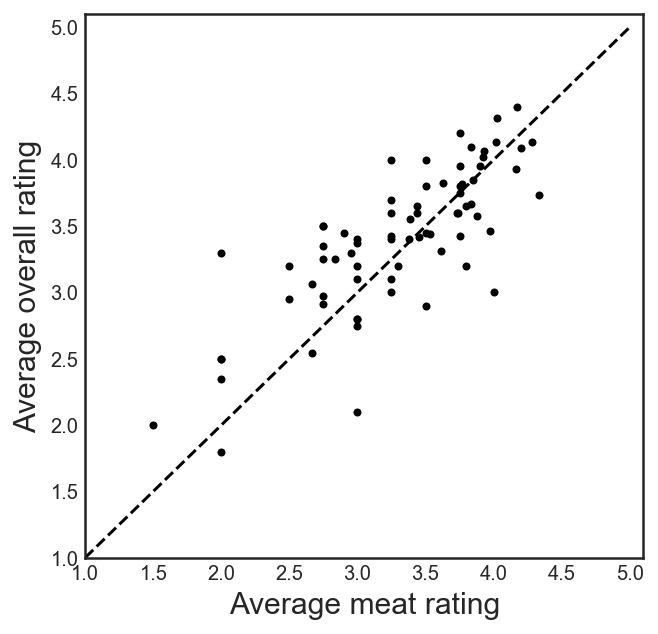

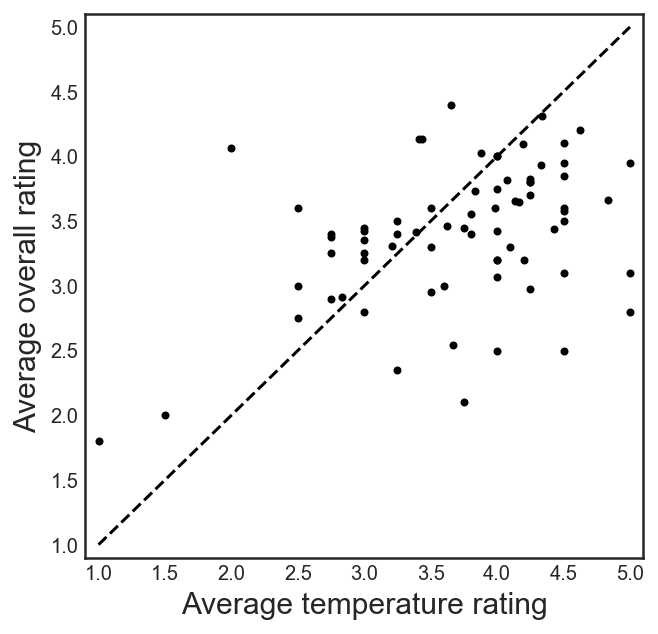

In [7]:
plt.figure(figsize=(5,5))
plt.plot(df_rest['Meat'], df_rest['overall'], 'k.')
plt.xlim((1,5.1))
plt.ylim((1,5.1))
plt.plot([1,5], [1,5], 'k--')
plt.xlabel('Average meat rating', size=15)
plt.ylabel('Average overall rating', size=15)

plt.figure(figsize=(5,5))
plt.plot(df_rest['Temp'], df_rest['overall'], 'k.')
plt.xlim((.9,5.1))
plt.ylim((.9,5.1))
plt.plot([1,5], [1,5], 'k--')
plt.xlabel('Average temperature rating', size=15)
plt.ylabel('Average overall rating', size=15)

### dendrogram to cluster burritos

<Figure size 720x1440 with 0 Axes>

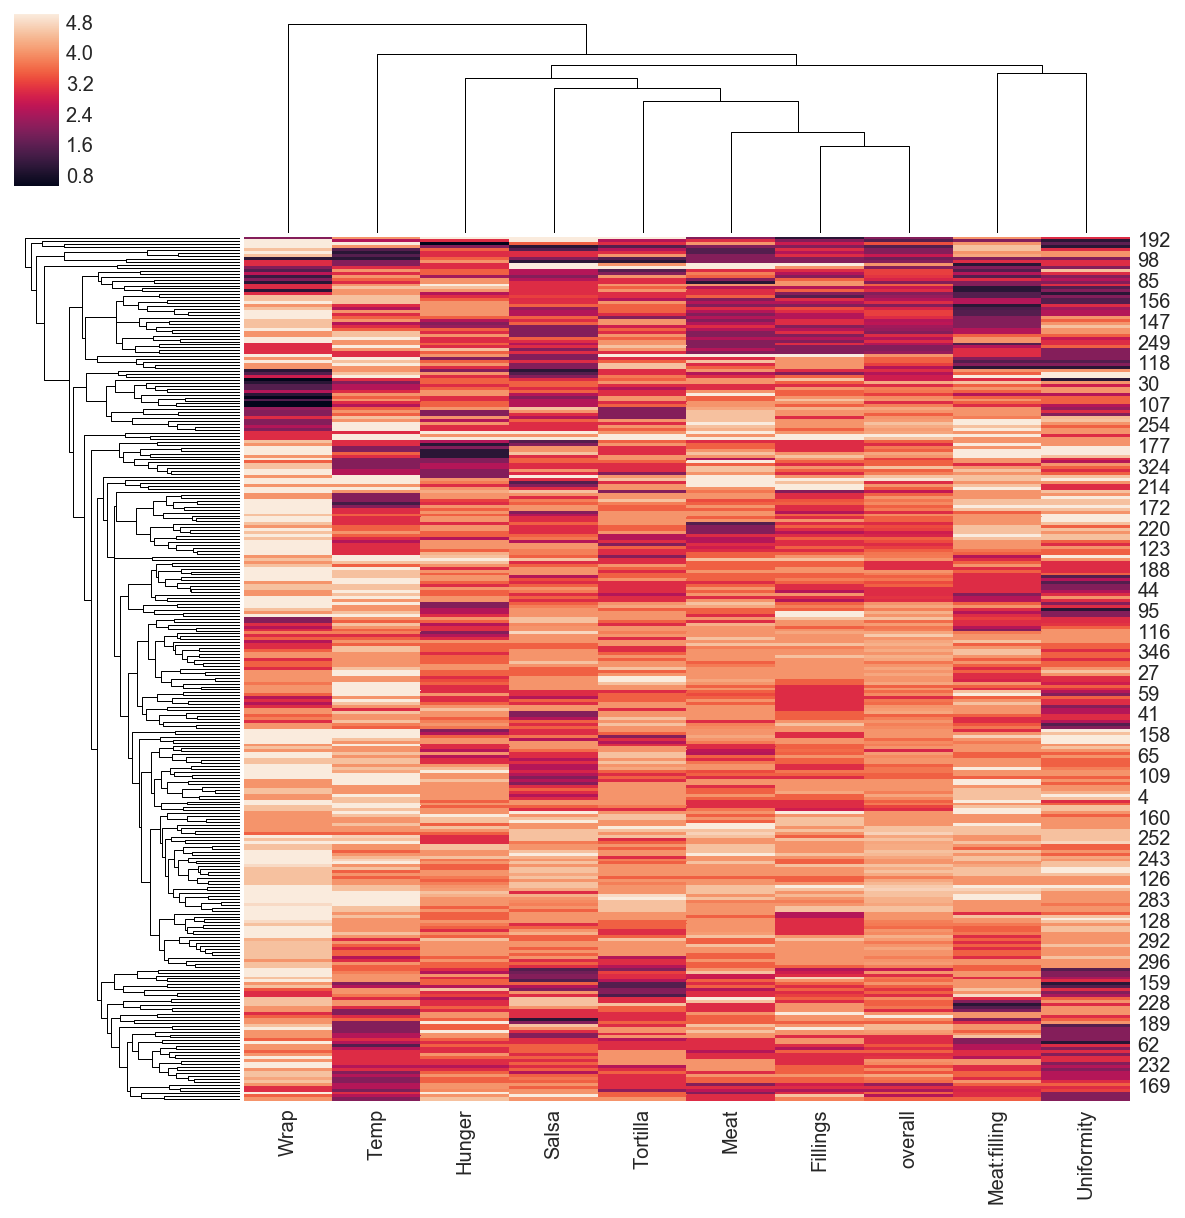

In [32]:
plt.figure(figsize=(10,20))
m_corr = ['Hunger','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Wrap','overall']
sns.clustermap(df_use[m_corr].dropna())

<Figure size 720x1440 with 0 Axes>

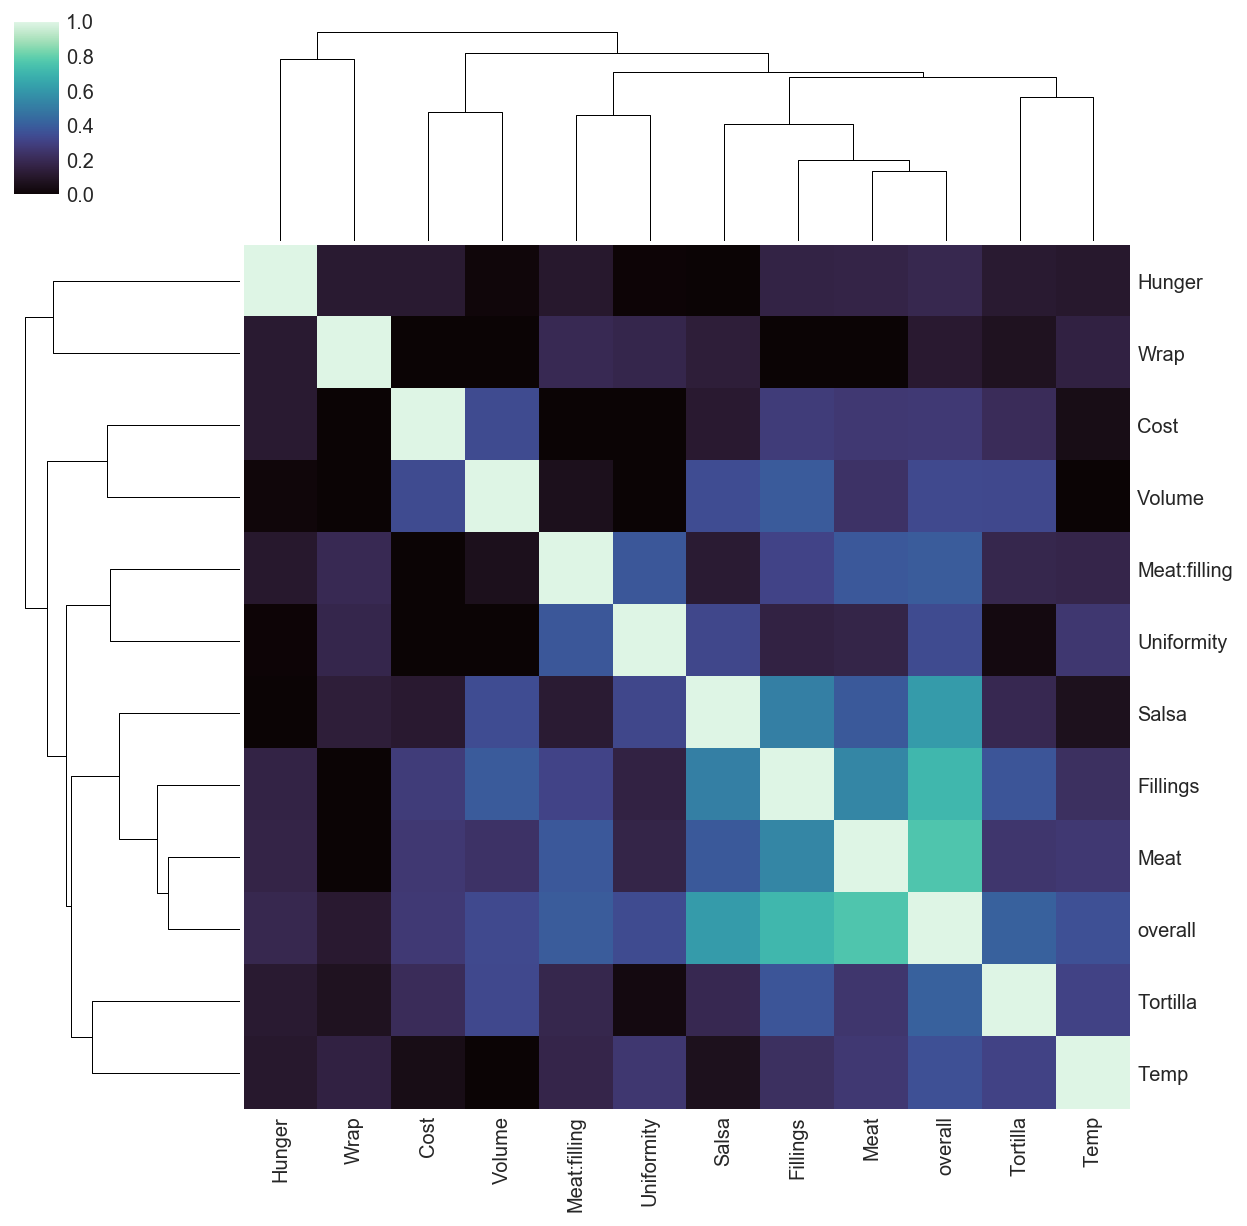

In [33]:
plt.figure(figsize=(10,20))
g = sns.clustermap(df_rest.corr(method='spearman'), vmin=0, vmax=1, cmap='mako')

# Hierarchy scipy dendrogram

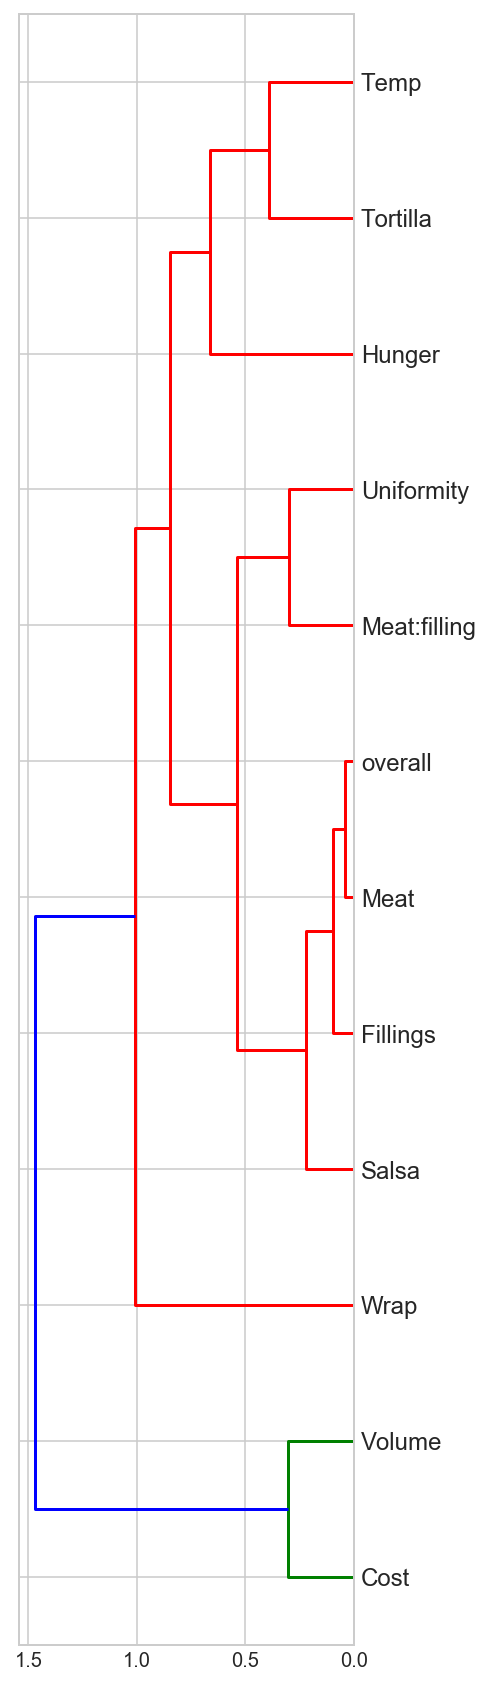

In [39]:
import scipy.cluster.hierarchy as hier

Y = hier.linkage(df_rest.corr(method='spearman'),
                 method='complete',
                 metric='cosine')

plt.figure(figsize=(3,15))

Z = hier.dendrogram(Y, orientation='left',
                    labels=df_rest.columns,
                    leaf_font_size=12)

# My ratings

In [10]:
# Compare GLMs for me and others
m_lm = ['Hunger','Tortilla','Temp','Meat','Fillings','Meat:filling',
        'Uniformity','Salsa','Wrap','Cost']

df_scott = df_use[df_use['Reviewer']=='scott']
df_emily = df_use[df_use['Reviewer']=='emily']
df_ricardo = df_use[df_use['Reviewer']=='ricardo']
df_notscott = df_use[df_use['Reviewer']!='scott']

# Remove incomplete data 
dffull = df_scott[np.hstack((m_lm,'overall'))].dropna()

# Run model and display results
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print('Explained variance: {:.1f}%'.format(100*(1 - np.var(res.resid_pearson) / np.var(y))))
print(res.summary())

# Remove incomplete data 
dffull = df_notscott[np.hstack((m_lm,'overall'))].dropna()

# Run model and display results
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print('Explained variance: {:.1f}%'.format(100*(1 - np.var(res.resid_pearson) / np.var(y))))
print(res.summary())

# Remove incomplete data 
dffull = df_emily[np.hstack((m_lm,'overall'))].dropna()

# Run model and display results
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print('Explained variance: {:.1f}%'.format(100*(1 - np.var(res.resid_pearson) / np.var(y))))
print(res.summary())

# Remove incomplete data 
dffull = df_ricardo[np.hstack((m_lm,'overall'))].dropna()

# Run model and display results
X = sm.add_constant(dffull[m_lm])
y = dffull['overall']
my_glm = sm.GLM(y,X)
res = my_glm.fit()
print('Explained variance: {:.1f}%'.format(100*(1 - np.var(res.resid_pearson) / np.var(y))))
print(res.summary())

Explained variance: 79.6%
                  Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                   116
Model:                            GLM   Df Residuals:                       105
Model Family:                Gaussian   Df Model:                            10
Link Function:               identity   Scale:              0.08790748873846721
Method:                          IRLS   Log-Likelihood:                 -17.793
Date:                Wed, 18 Apr 2018   Deviance:                        9.2303
Time:                        09:18:56   Pearson chi2:                      9.23
No. Iterations:                     2                                          
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.7351      0.349     -2.103      0.035      -1.420      -0.050
Hunger     

In [11]:
df_use['Reviewer'].value_counts()

scott           121
emily            47
ricardo          16
sage             12
elynn            10
luis              9
richard           9
brent             8
tom               6
erin              6
matteo            4
hannah            4
erik              3
bankole           3
marc              3
aga               2
katie             2
nuttida           2
sankha g          2
kelsey            2
cris              2
tara              2
mike              2
devleena          2
ben s             2
sandra            1
simon             1
daniel a          1
erik k            1
eli               1
               ... 
brad              1
torben            1
xi                1
@synapticlee      1
rob l             1
tammy             1
dan               1
leo               1
chris g           1
benni             1
han mee           1
rob               1
nihal             1
jaeyoung          1
brad p            1
javier            1
melissa g         1
justin k          1
aaron s           1


In [12]:
df_use['Location'].value_counts()

lucha libre north park             27
california burritos                26
taco stand                         23
rigoberto's taco shop              22
taco villa                         17
vallarta express                   13
los tacos                          13
lolita's taco shop                 11
los primos mexican food             9
valentines mexican food             8
el zarape                           8
cancun mexican & seafood            6
california burrito company          5
lupe's taco shop                    4
mikes taco club                     4
los tacos 2                         4
rigoberto's taco shop la jolla      4
tony's fresh mexican food           4
ortiz's taco shop #2                4
caliente mexican food               4
el dorado mexican food              4
porkyland                           4
burros and fries                    4
roberto's taco shop clairemont      4
taco stand encinitas                4
taco surf pb                        3
colima's mex

# Compare restaurants in each dimension

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0, 1)

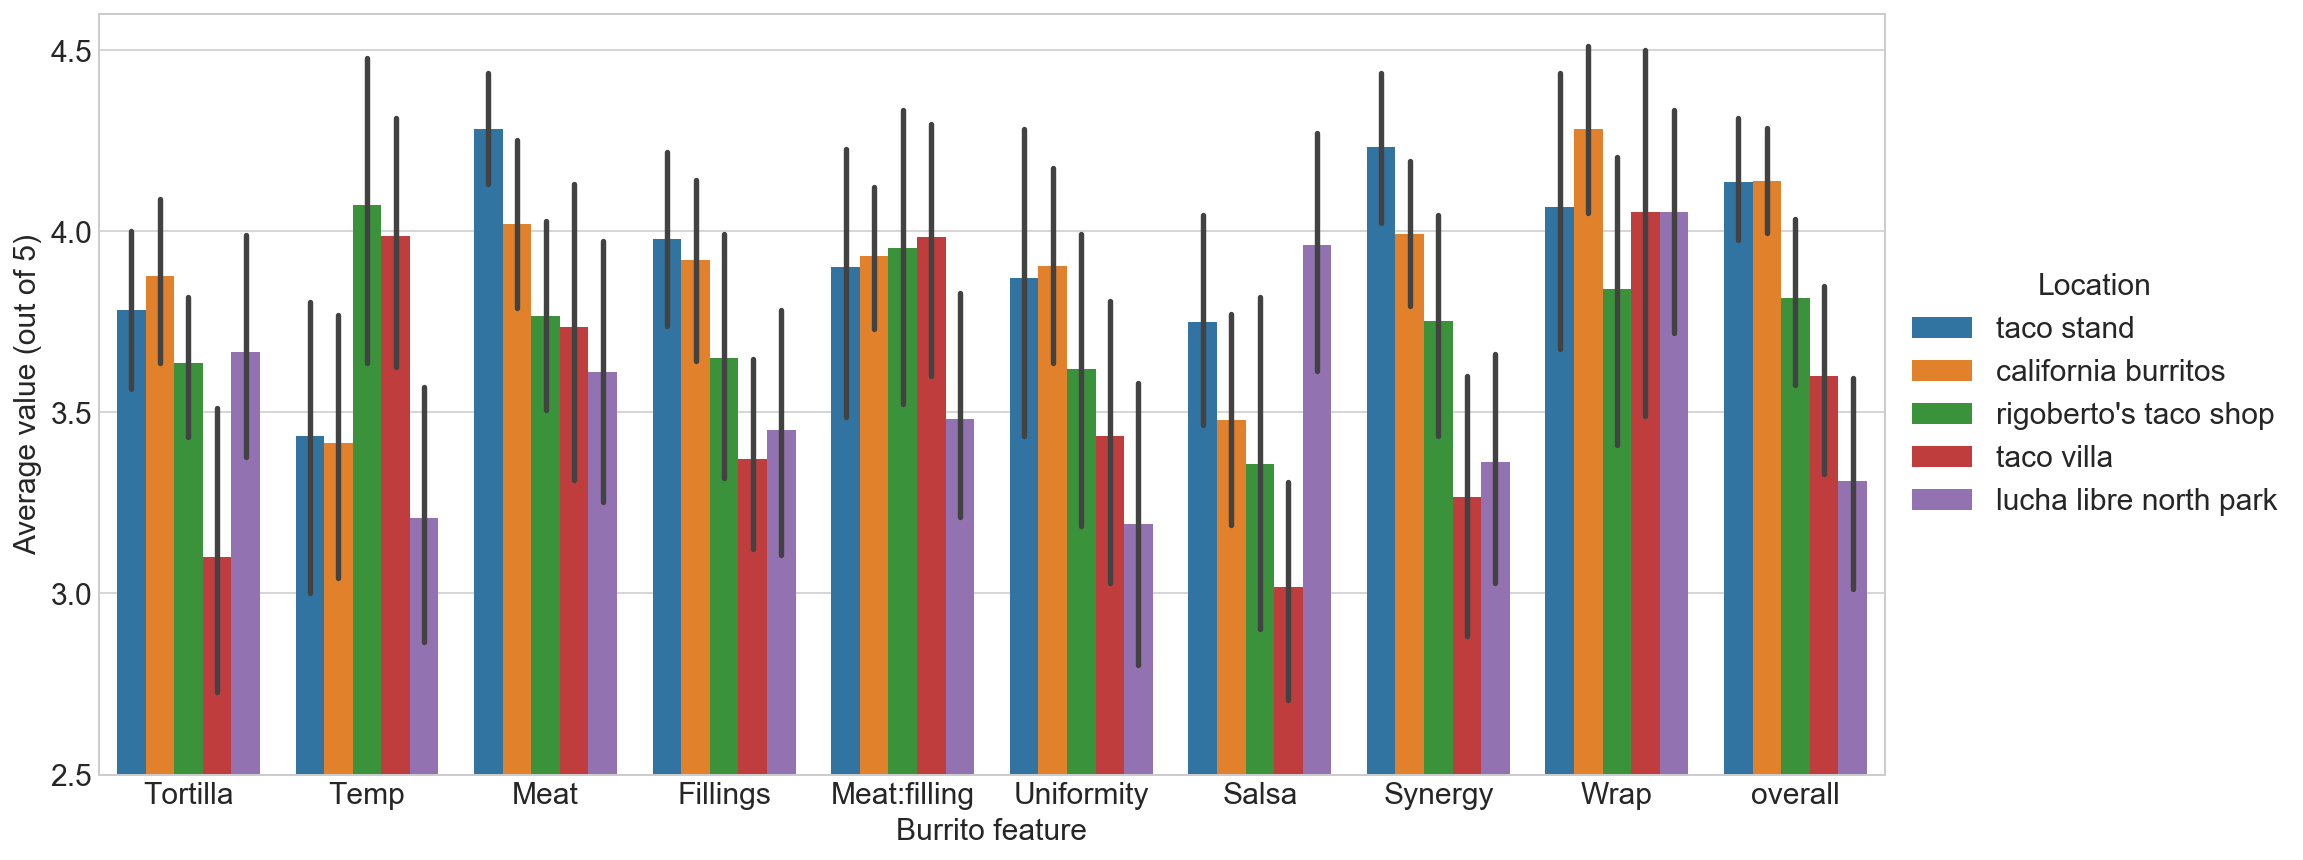

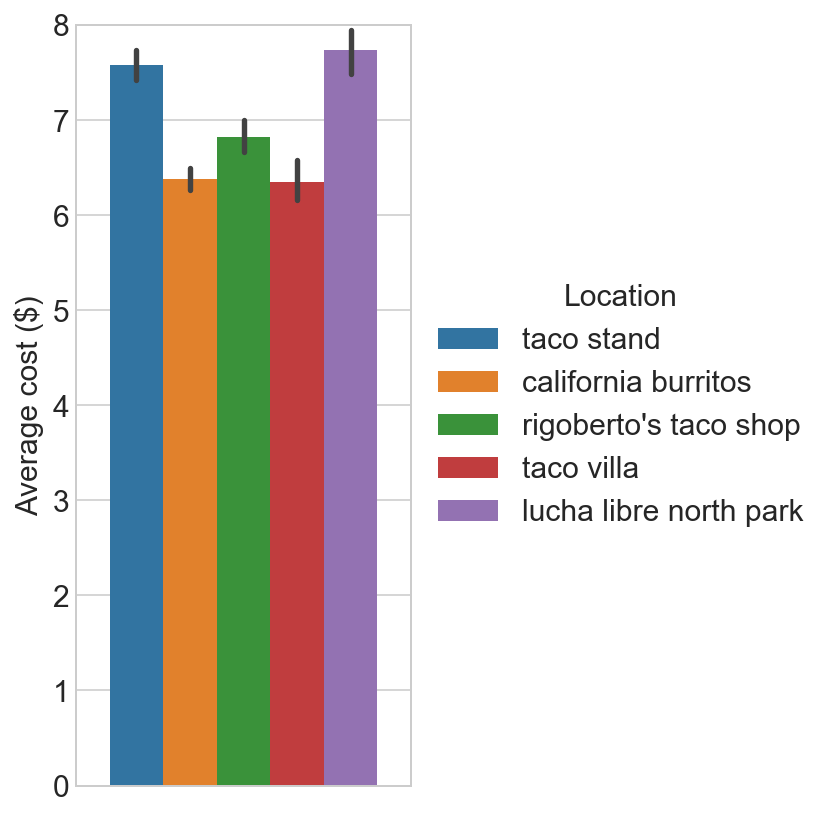

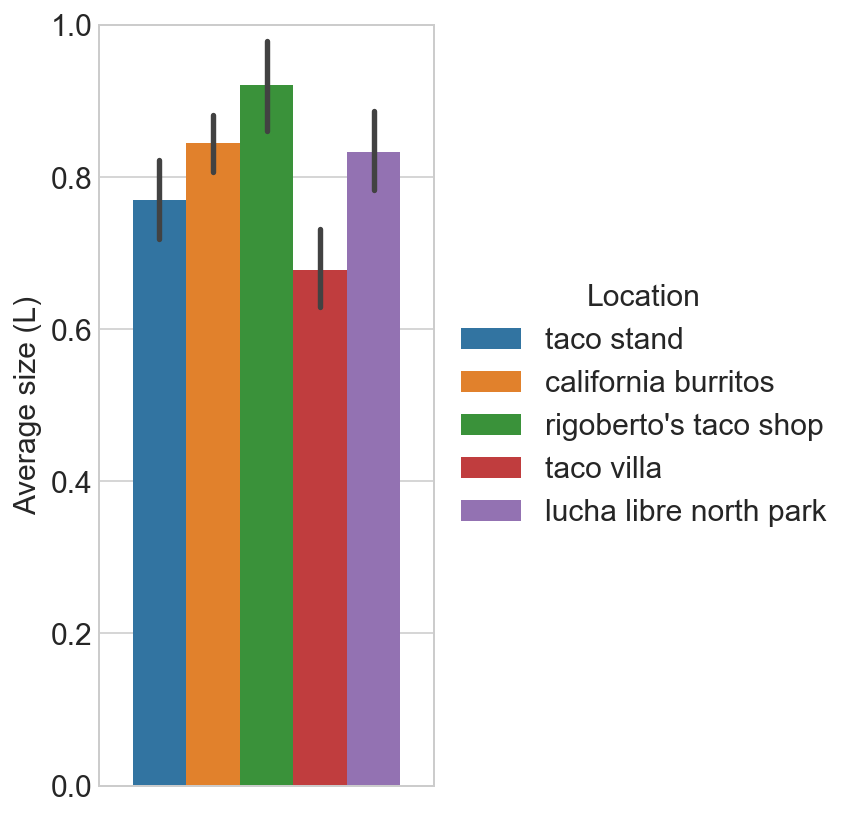

In [13]:
sns.set_style('whitegrid')
restaurants_compare = ['taco stand', 'california burritos', "rigoberto's taco shop", 'taco villa', 'lucha libre north park']

m_lm = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
df_plt = df_use[df_use['Location'].isin(restaurants_compare)]
df_plt = df_plt[np.hstack((m_lm,'Location'))]
df_plt.set_index('Location', inplace=True)
df_plt = df_plt.stack().reset_index().rename(columns={'level_1': 'feature', 0: 'value'})

plt.figure(figsize=(16,7))
sns.barplot(x='feature', y='value', hue='Location', data=df_plt, hue_order=restaurants_compare)
plt.gca().legend(title='Location', fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(plt.gca().get_legend().get_title(), fontsize='15')
plt.xticks(size=15)
plt.yticks(np.arange(2.5,5,.5), size=15)
plt.xlabel('Burrito feature', size=15)
plt.ylabel('Average value (out of 5)', size=15)
plt.ylim((2.5,4.6))


m_lm = ['Cost']
df_plt = df_use[df_use['Location'].isin(restaurants_compare)]
df_plt['dummy'] = 1

plt.figure(figsize=(3,7))
sns.barplot(x='dummy', y='Cost', hue='Location', data=df_plt, hue_order=restaurants_compare)
plt.gca().legend(title='Location', fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(plt.gca().get_legend().get_title(), fontsize='15')
plt.xticks([])
plt.yticks(np.arange(0,9), size=15)
plt.xlabel('')
plt.ylabel('Average cost ($)', size=15)
plt.ylim((0,8))

m_lm = ['Volume']
df_plt = df_use[df_use['Location'].isin(restaurants_compare)]
df_plt['dummy'] = 1

plt.figure(figsize=(3,7))
sns.barplot(x='dummy', y='Volume', hue='Location', data=df_plt, hue_order=restaurants_compare)
plt.gca().legend(title='Location', fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(plt.gca().get_legend().get_title(), fontsize='15')
plt.xticks([])
plt.yticks(np.arange(0,1.1,.2), size=15)
plt.xlabel('')
plt.ylabel('Average size (L)', size=15)
plt.ylim((0, 1))

# Most distinctive feature
Difference between across-restaurant variance and within-restaurant variance

,across shop,within : across,within shop
Volume,0.011122,0.707134,0.007865
Cost,0.649593,0.352785,0.229167


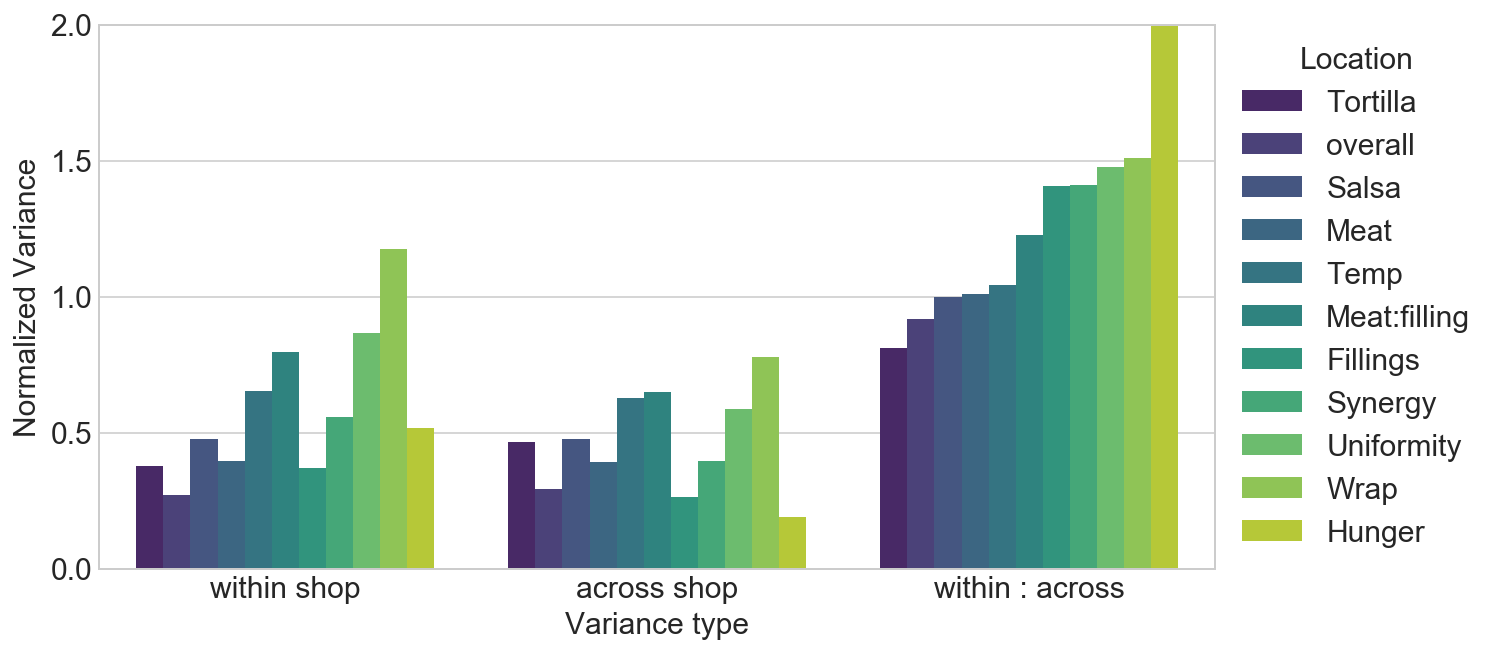

In [14]:
feats = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall', 'Hunger']

# Compute variance within restaurants
var_within_rest = df_use.groupby('Location')[feats].var().mean()
var_across_rest = df_use.groupby('Location')[feats].mean().var()
var_within_by_across = var_within_rest / var_across_rest

df_var = pd.DataFrame({'within shop': var_within_rest,
                       'across shop': var_across_rest, 
                       'within : across': var_within_by_across})
df_var = df_var.stack().reset_index().rename(columns={'level_0':'Feature', 'level_1': 'type', 0: 'Variance'})

plt.figure(figsize=(10,5))
sns.barplot(x='type', y='Variance', hue='Feature', data=df_var, palette='viridis',
            hue_order=var_within_by_across.sort_values().index,
            order = ['within shop', 'across shop', 'within : across'])
plt.gca().legend(title='Location', fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(plt.gca().get_legend().get_title(), fontsize='15')
plt.xlabel('Variance type', size=15)
plt.ylabel('Normalized Variance', size=15)
plt.xticks(size=15)
plt.yticks(np.arange(0, 2.5, .5), size=15)
plt.ylim((0,2))

feats = ['Volume', 'Cost']

# Compute variance within restaurants
var_within_rest = df_use.groupby('Location')[feats].var().mean()
var_across_rest = df_use.groupby('Location')[feats].mean().var()
var_within_by_across = var_within_rest / var_across_rest
df_var = pd.DataFrame({'within shop': var_within_rest,
                       'across shop': var_across_rest, 
                       'within : across': var_within_by_across})
df_var.head()

# Distribution of features

(1, 5)

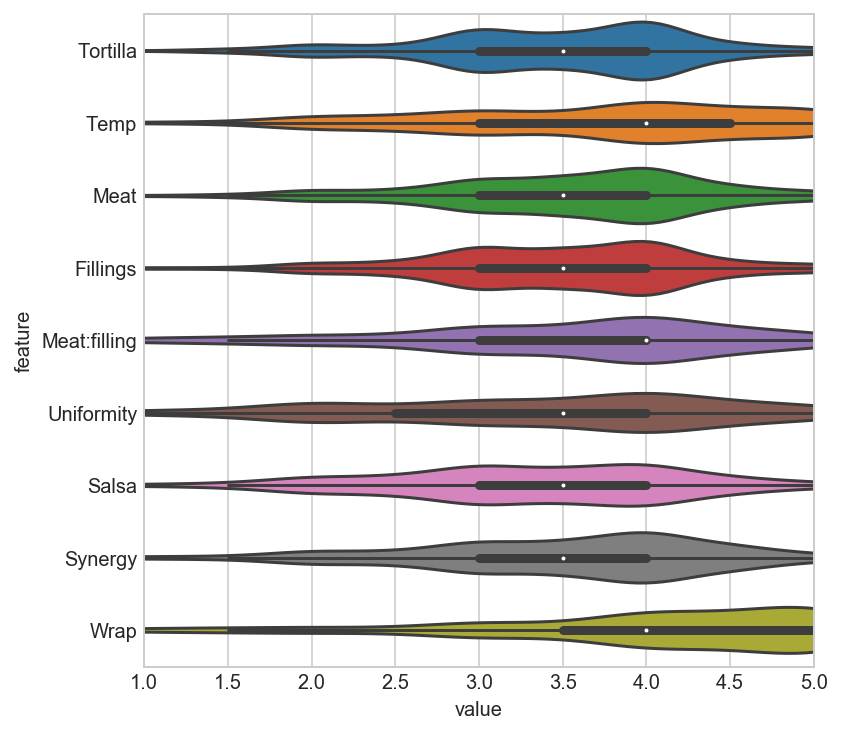

In [30]:
cols_plot = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
df_plt = df[cols_plot]
df_plt = df_plt.stack().reset_index().drop('level_0', axis=1).rename(columns={'level_1': 'feature', 0: 'value'})

plt.figure(figsize=(6,6))
sns.violinplot(y='feature', x='value', data=df_plt)
plt.xlim((1,5))